# 1. Title and Executive Summary


### Sleep Health and Lifestyle Data Analysis

- Erin Hearn
- IT2053C

This project focuses on an analysis of the Sleep Health and Lifestyle dataset, summarized in the data card section below.  Key focuses of the analysis are which demographic and health factors most influence sleep.  This notebook contains:
- **Data card** summarizing the dataset origin, fields, units, limitations, and license
- **Loading and File IO** section detailing how the dataset was imported
- **Exploratory data analysis** of the dataset including statistical insights and visualizations
- **Conclusions**, summarizing my findings based on the EDA
- **Appendix**, resources and references 

# 2. Data Card

### Dataset Overview

- **Dataset Origin**: Kaggle 
- **Dataset Link**: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset
- **Fields**: 
  - Person ID: An identifier for each individual. (no units)
  - Gender: The gender of the person (Male/Female).
  - Age: Age of individual in years. 
  - Occupation: Profession of the individual. (categorical - job titles)
  - Sleep Duration: Duration of sleep in hours 
  - Quality of Sleep: Subjective rating of sleep on a scale of 1-10 (unitless subjective score)
  - Physical Activity Level: Minutes of physical activity per day
  - Stress Level: Subjective rating of stress level on a scale of 1-10 (unitless subjective score)
  - BMI Category: The BMI category of the person (Underweight, Normal, Overweight).
  - Blood Pressure: blood pressure measurement of the person, (systolic/diastolic). 
  - Heart Rate: The resting heart rate in beats per minute. 
  - Daily Steps: Number of steps taken per day. 
  - Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).
- **Limitations**: This is a synthetic dataset created for educational purposes, so the data may contain logical or technical errors.
- **License**: Public Domain


# 3. Loading and File IO

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# plotly fix:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [93]:
# Data Loading
pd.set_option('display.max_columns', None)
sleepy_path = 'data/SleepyData.csv'
try:
  SleepyData = pd.read_csv(sleepy_path)
except FileNotFoundError:
  print(f"Error: {sleepy_path} not found. Check data / folder and file name")

except pd.errors.ParserError:
  print(
      f"Error: Parsing failed for {sleepy_path}. check delimiter or bad rows.")
else:
  print("Sleepy data loaded successfully!")
  print(SleepyData.info())

Sleepy data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage

### Data Cleaning and Optimization

1. Currently, sleep quality and stress levels are rated 1-10. I'm converting them to categorical (low, moderate, high) in order to group by these categories in later steps. 

In [94]:
# Data Cleaning and Optimization

# Converting sleep quality and stress level to categorical data types (low, moderate, high).
# Currently, they are measured on a scale of 1-10.
# Using if/elif to map the numerical values to categorical labels.

# Checking the min and max values of each category before converting to categorical

print("\nBefore converting Sleep Quality and Stress Level to categorical:")
print("Quality of Sleep raw min/max:",
      SleepyData["Quality of Sleep"].min(), SleepyData["Quality of Sleep"].max())
print("Stress Level raw min/max:",
      SleepyData["Stress Level"].min(), SleepyData["Stress Level"].max())

# Converting to int to ensure the categorize levels function will work
SleepyData["Quality of Sleep"] = pd.to_numeric(
    SleepyData["Quality of Sleep"], errors="coerce")
SleepyData["Stress Level"] = pd.to_numeric(
    SleepyData["Stress Level"], errors="coerce")

# Categorizing into low (<=3), moderate (4-7), and high (>=8)


def categorize_levels(value: int) -> str:
  if value <= 3:
    return 'low'
  elif 4 <= value <= 7:
    return 'moderate'
  else:
    return 'high'


# Applying the categorization
SleepyData["Quality of Sleep"] = SleepyData["Quality of Sleep"].apply(
    categorize_levels).astype("category")
SleepyData["Stress Level"] = SleepyData["Stress Level"].apply(
    categorize_levels).astype("category")

# Printing the results
# they match the min and max values (Nobody rated quality of sleep less than 3, so there are no low values)
print("\nAfter converting Sleep Quality and Stress Level to categorical:")
print(SleepyData["Quality of Sleep"].unique())
print(SleepyData["Stress Level"].unique())


Before converting Sleep Quality and Stress Level to categorical:
Quality of Sleep raw min/max: 4 9
Stress Level raw min/max: 3 8

After converting Sleep Quality and Stress Level to categorical:
['moderate', 'high']
Categories (2, object): ['high', 'moderate']
['moderate', 'high', 'low']
Categories (3, object): ['high', 'low', 'moderate']


2. I am adding an age groups column to the data set in order to group by age more efficiently. 
- Grouping ages into young adult (<35), adult (<50), and middle aged (>50). Ages range from 27-59.
- Using merge with SleepyData to add the age groups column

In [95]:
# Grouping ages into young adult (<35), adult (<50), and middle aged (>50). Ages range from 27-59.

age_groups = pd.DataFrame({
    'Age': SleepyData['Age'],
    'Age Group': pd.cut(SleepyData['Age'], bins=[26, 34, 49, 60],
                        labels=['young adult', 'adult', 'middle aged'])
})
# Using merge with SleepyData to add the age groups column
SleepyData_merged = SleepyData.merge(age_groups, on="Age", how="left")

# Test of merge: print(SleepyData_merged[["Person ID","Age","Age Group","Sleep Duration"]].head())

3. Prepping Raw Data for Visualizations
<br>
This code blocks below contain several functions to prepare my raw data for visualizations:  
- Dict mapping for sleep disorder
- Eliminating duplicate values in the occupation column with set
- Pivot table for visualization: average Sleep Duration by Occupation and Stress Level
- Grouping by gender and calculating sleep duration (touple)
- Grouping by stress level and calculate sleep duration
- Grouping by age groups and calculate sleep duration

In [96]:
# Dict mapping for Sleep Disorder
disorder_map = {"None": 0, "Insomnia": 1, "Sleep Apnea": 2}
SleepyData["SleepDisorder_Code"] = SleepyData["Sleep Disorder"].map(
    disorder_map)

In [97]:
# Emilinating duplicate occupations
unique_occupations = set(SleepyData["Occupation"])
# test of unique occupations: print("Unique Occupations:", unique_occupations)

In [98]:
# Pivot table for visualization: average Sleep Duration by Occupation and Stress Level
occupation_metrics_pivot = SleepyData.pivot_table(
    index="Occupation",
    columns="Stress Level",
    values="Sleep Duration",
    aggfunc="mean"
)
# Test of pivot: print(occupation_metrics_pivot)

C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\1619078677.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [99]:
# Group by gender and calculate sleep duration (touple)
gender_sleep_stats = SleepyData.groupby("Gender").agg({
    "Sleep Duration": ("mean", "std")
}).reset_index()

In [100]:
# group by stress level and calculate sleep duration
stress_sleep_duration = SleepyData.groupby("Stress Level").agg({
    "Sleep Duration": "mean",
}).reset_index()

C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\70877577.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [101]:
# Group by age groups and calculate sleep duration
agegroup_sleep_duration = SleepyData_merged.groupby("Age Group").agg({
    "Sleep Duration": "mean",
}).reset_index()

C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\3916678965.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Exploratory Data Analysis (EDA) - Statistical Insights and Visualizations

### Statistical Insight 1: 
Instructions: 
- Distribution characterization of a key outcome. center, spread, skew, and outliers. include a figure and a tidy summary table.

Decisions:
- Naturally, I chose sleep duration, as it's central to the dataset. 
- Understanding sleep duration metrics will allow us to make further insights on how certain factors may impact sleep duration. 
Practical Implications:
- Most individuals sleep within a normal or moderate range, with the mean hovering at 7
- No outliers detected (minimum of 5.8 and maximum of 8.5, both within normal range) 

Results:
- Mean                7.132086
- Median              7.200000
- Mode                7.200000
- Standard Deviation  0.795657
- Variance            0.633070
- Skewness            0.037554
- Kurtosis           -1.286506
- Min                 5.800000
- Max                 8.500000

In [103]:
# Statistical Insight 1: Distribution of sleep duration.
# summary table of: center, spread, skew, and outliers.
sleep_duration_stats = {
    "Mean": SleepyData["Sleep Duration"].mean(),
    "Median": SleepyData["Sleep Duration"].median(),
    "Mode": SleepyData["Sleep Duration"].mode()[0],
    "Standard Deviation": SleepyData["Sleep Duration"].std(),
    "Variance": SleepyData["Sleep Duration"].var(),
    "Skewness": SleepyData["Sleep Duration"].skew(),
    "Kurtosis": SleepyData["Sleep Duration"].kurtosis(),
    "Min": SleepyData["Sleep Duration"].min(),
    "Max": SleepyData["Sleep Duration"].max()
}
# Creating dataframe with the sleep duration stats:
sleep_duration_stats_df = pd.DataFrame.from_dict(
    sleep_duration_stats, orient='index', columns=['Value']
)
print("\nSleep Duration Statistics DataFrame:")
print(sleep_duration_stats_df)


Sleep Duration Statistics DataFrame:
                       Value
Mean                7.132086
Median              7.200000
Mode                7.200000
Standard Deviation  0.795657
Variance            0.633070
Skewness            0.037554
Kurtosis           -1.286506
Min                 5.800000
Max                 8.500000


### Visualization: Histogram of Sleep Duration Stats
- This histogram visualizes the distribution of sleep duration with a KDE overlay, providing additional insight to the sleep duration stats above. 
- No extreme outliers seen, matching the previous sleep duration stats table. 

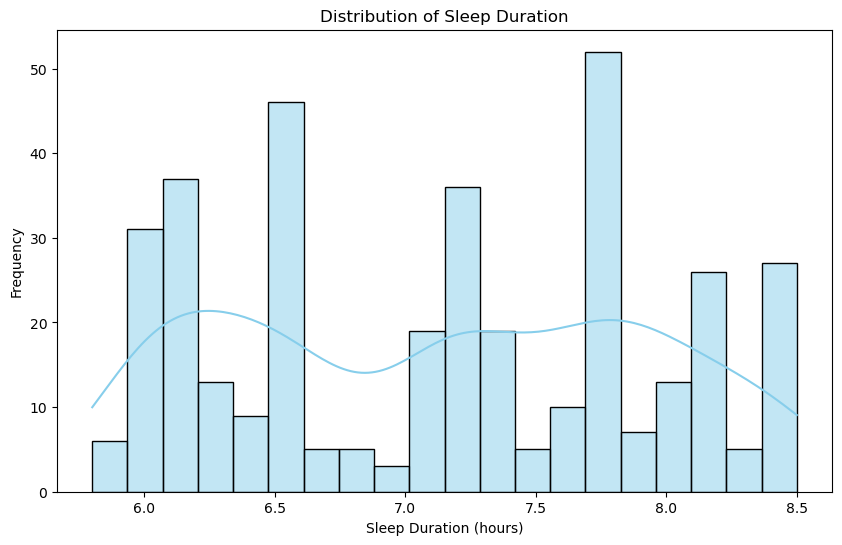

In [104]:
# Figure: Histogram of Sleep Duration stats
plt.figure(figsize=(10, 6))
sns.histplot(SleepyData["Sleep Duration"], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Sleep Duration")
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Frequency")
plt.show()

### Statistical Insight 2: Group compaison of gender on sleep duration.
Instructions: 
- Group comparison on a numeric variable. independent t test or Welch or nonparametric alternative. report effect size and 95 percent CI.

Decisions:
- I chose gender vs sleep duration for this comparison to determine if gender strongly influences sleep duration. 
- I chose Welch's t test (two independant groups)

Result:
- Mean difference: -0.19 hours (women sleep longer on average)
- Welch's t test: t = –2.36, p = 0.019
- Effect size (Cohen’s d): –0.24 (small)
- 95% CI for mean difference: [–0.35, –0.03] hrs

- Taken together, these results showcase that women sleep slightly longer (0.3-0.35 or 1.8-21 minutes)
- This is a small but statistically significant difference. 

Sources:
- https://www.geeksforgeeks.org/machine-learning/welchs-t-test-in-python/
- https://www.datanovia.com/en/lessons/t-test-effect-size-using-cohens-d-measure/
- https://machinelearningmastery.com/effect-size-measures-in-python/
- https://datagy.io/python-confidence-intervals/


In [ ]:
# Statistical Insight 2: Group compaison of gender on sleep duration.
# Group comparison on a numeric variable. independent t test or Welch or nonparametric alternative. report effect size and 95 percent CI.
# Created earlier: Group by gender and calculate sleep duration (touple)
import scipy.stats as stats
gender_sleep_stats = SleepyData.groupby("Gender").agg({
    "Sleep Duration": ("mean", "std")
}).reset_index()
# t-test:
male_sleep = SleepyData[SleepyData["Gender"] == "Male"]["Sleep Duration"]
female_sleep = SleepyData[SleepyData["Gender"] == "Female"]["Sleep Duration"]
t_stat, p_value = stats.ttest_ind(male_sleep, female_sleep, equal_var=False)
# effect size (Cohen's d)
mean_diff = male_sleep.mean() - female_sleep.mean()
pooled_sd = np.sqrt(((male_sleep.std(ddof=1)**2) +
                    (female_sleep.std(ddof=1)**2)) / 2)
cohens_d = mean_diff / pooled_sd

# 95% CI for the difference in means
se_diff = np.sqrt(male_sleep.var(ddof=1)/len(male_sleep) +
                  female_sleep.var(ddof=1)/len(female_sleep))
df_num = (male_sleep.var(ddof=1)/len(male_sleep) +
          female_sleep.var(ddof=1)/len(female_sleep))**2
df_den = ((male_sleep.var(ddof=1)/len(male_sleep))**2/(len(male_sleep)-1) +
          (female_sleep.var(ddof=1)/len(female_sleep))**2/(len(female_sleep)-1))
df = df_num/df_den
ci_range = stats.t.ppf(0.975, df) * se_diff
ci_low, ci_high = mean_diff - ci_range, mean_diff + ci_range
# Printing t-test results
print("\nGroup Comparison: Sleep Duration by Gender")
print(gender_sleep_stats)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
print(f"Mean difference = {mean_diff:.2f} hrs")
print(f"Cohen's d = {cohens_d:.2f}")
print(f"95% CI for mean difference = [{ci_low:.2f}, {ci_high:.2f}]")


Group Comparison: Sleep Duration by Gender
   Gender Sleep Duration          
                    mean       std
0  Female       7.229730  0.879434
1    Male       7.036508  0.693197

Welch's t-test: t = -2.357, p = 0.019
Mean difference = -0.19 hrs
Cohen's d = -0.24
95% CI for mean difference = [-0.35, -0.03]


### Statistical Insight 3: 
Instructions: 
- Association between two categorical variables. chi square or Fisher when appropriate. include a proportion plot with CIs.

Decisions:
- I chose to examine sleep quality vs stress level for this association, which I coded to categorical valeus (low, moderate, high) earlier
- I chose chi test over fisher because my sample size was larger (300+)

Results: 
- Interestingly, no individuals rated their quality of sleep low, no matter the stress level
- As expected, high sleep quality was more common with low-moderate sleep levels 
- Moderate sleep level was most common when individuals rated high stress
- This suggests stress has a strong influence on sleep

Source:
- https://www.graphpad.com/guides/prism/latest/statistics/stat_chi-square_or_fishers_test.htm
- https://www.geeksforgeeks.org/python/python-pearsons-chi-square-test/


In [ ]:
# Statistical Insight 3: Association between two categorical variables. chi square or Fisher when appropriate.
# include a proportion plot with CIs.

# association between Sleep Quality and Stress Level

import scipy.stats as stats
import seaborn as sns

contingency_table = pd.crosstab(
    SleepyData["Quality of Sleep"], SleepyData["Stress Level"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
# Printing chi-square test results
print("\nAssociation between Sleep Quality and Stress Level")
print("Contingency Table:")
print(contingency_table)
print(f"\nChi-square test: chi2 = {chi2:.3f}, p = {p:.3f}, dof = {dof}")


Association between Sleep Quality and Stress Level
Contingency Table:
Stress Level      high  low  moderate
Quality of Sleep                     
high                 0   71       109
moderate            70    0       124

Chi-square test: chi2 = 141.640, p = 0.000, dof = 2


### Visualization: Proportion of Stress Level by Sleep Quality
- This visualization further illustrates the findings of statistical insight 3: association between Sleep Quality and Stress Level

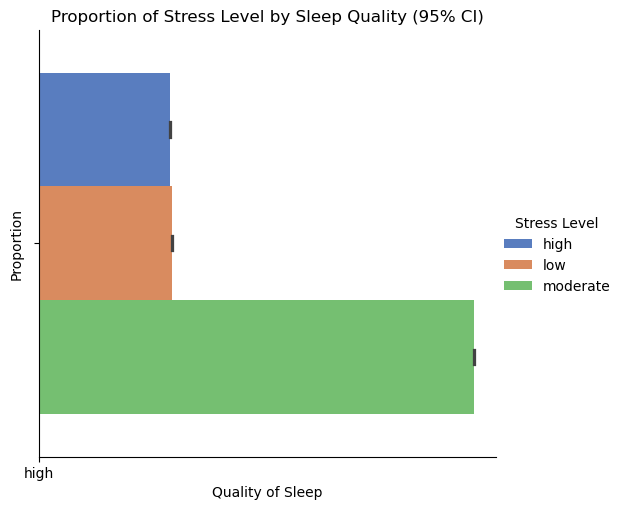

In [117]:
# Proportion plot with CIs
sns.catplot(
    data=SleepyData, kind="bar",
    x="Quality of Sleep", y=None, hue="Stress Level",
    estimator=lambda x: len(x) / len(SleepyData),
      errorbar=('ci', 95), capsize=0.1, palette="muted"
)
plt.title("Proportion of Stress Level by Sleep Quality (95% CI)")
plt.ylabel("Proportion")
plt.show()

### Statistical Insight 4:
Instructions: 
- Correlation between two numeric variables. Pearson or Spearman based on diagnostics. include a CI for the correlation and an annotated scatter with a fitted line.

Decisions:
- I chose sleep duration vs physical activity level for this correlation
- Both Pearson and Spearman were used to view diagnostics
- Pearson was the better choice for this correlation due to the normal distribution of sleep duration seen earlier

Results:
- Pearson r = 0.212 and Spearman ρ = 0.209
- This suggests increased physical activity has small positive impact on sleep duration 

Sources: 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
- https://www.statology.org/seaborn-scatterplot-with-correlation-coefficient/
- https://seaborn.pydata.org/generated/seaborn.regplot.html
- https://tidystat.com/conduct-correlation-in-python/
- https://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlation
- https://www.surveymonkey.com/market-research/resources/pearson-correlation-vs-spearman-correlation/


In [118]:
# Statistical Insight 4: Correlation between two numeric variables. Pearson or Spearman based on diagnostics.
# include a CI for the correlation and an annotated scatter with a fitted line.
# numeric values: sleep duration and physical activity level
import scipy.stats as stats

spearman_r, spearman_p = stats.spearmanr(
    SleepyData["Sleep Duration"], SleepyData["Physical Activity Level"])
print(
    f"Spearman correlation coefficient: rho = {spearman_r:.3f}, p = {spearman_p:.3f}")

corr_coef, p_value = stats.pearsonr(
    SleepyData["Sleep Duration"], SleepyData["Physical Activity Level"])

# CI for correlation


def fisher_z_ci(r, n, alpha=0.05):
  z = np.arctanh(r)
  se = 1 / np.sqrt(n - 3)
  z_crit = stats.norm.ppf(1 - alpha / 2)
  ci_low = np.tanh(z - z_crit * se)
  ci_high = np.tanh(z + z_crit * se)
  return ci_low, ci_high


ci_low, ci_high = fisher_z_ci(corr_coef, len(SleepyData))
print(f"95% CI for r: [{ci_low:.3f}, {ci_high:.3f}]")

# Printing correlation results
print("\nCorrelation between Sleep Duration and Physical Activity Level")
print(
    f"Pearson correlation coefficient: r = {corr_coef:.3f}, p = {p_value:.3f}")

Spearman correlation coefficient: rho = 0.209, p = 0.000
95% CI for r: [0.113, 0.307]

Correlation between Sleep Duration and Physical Activity Level
Pearson correlation coefficient: r = 0.212, p = 0.000


### Visualization: Scatter Plot of Sleep Duration vs Physical Activity Level
- This scatter plot further illustrates the findings of statistical insight 4: Correlation between Sleep Duration and Physical Activity Level
- As expected, the small positive impact on sleep duration can be seen

Sources
- https://pytutorial.com/python-seaborn-regplot-scatter-plots-with-regression/

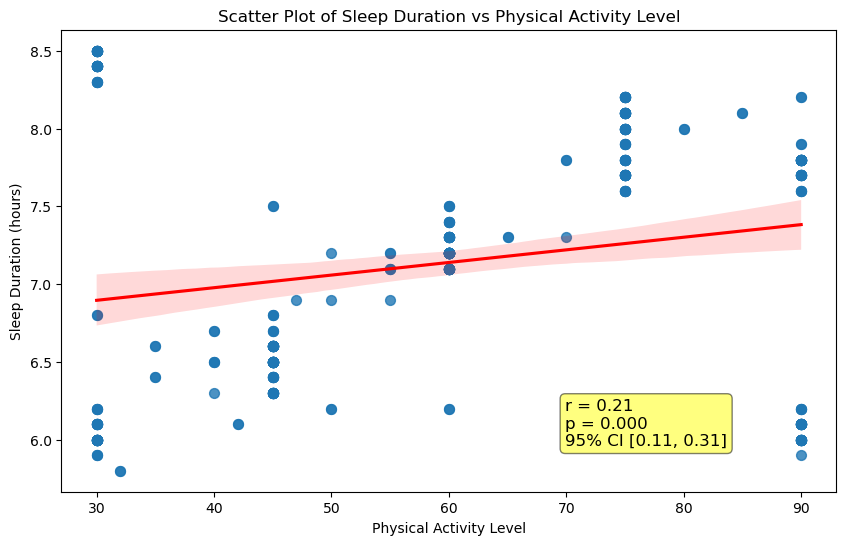

In [119]:
# Scatter plot with fitted line
plt.figure(figsize=(10, 6))
sns.regplot(
    x="Physical Activity Level", y="Sleep Duration",
    data=SleepyData, scatter_kws={"s": 50}, line_kws={"color": "red"}
)
plt.title("Scatter Plot of Sleep Duration vs Physical Activity Level")
plt.xlabel("Physical Activity Level")
plt.ylabel("Sleep Duration (hours)")
plt.annotate(f"r = {corr_coef:.2f}\np = {p_value:.3f}\n95% CI [{ci_low:.2f}, {ci_high:.2f}]",
             xy=(0.65, 0.1), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5))
plt.show()

### Statistical Insight 5: 
Instruction: N/A

Decision:
- For my fifth statistical insight, I chose to perform a group compaison of raw age on sleep duration.
- This utilizes my categorical age groups created ealier, comparing them to sleep duration. 
- After some research, I determined ANOVA was the best tool for this comparison since I'm using a numerical variable vs a categorical vairable with three "levels." 

Results: 
- ANOVA test: F = 265.588, p = 0.000 
- This means there is a large/statistically significant difference in sleep level by age group 
- Middle aged individuals sleep the most on average at about 7.5 hours
- Young individuals sleep the least on average at 6.8 hours

Sources:
- https://www.statology.org/understanding-anova-when-and-how-to-use-it-in-your-research/
- https://www.geeksforgeeks.org/python/how-to-perform-a-one-way-anova-in-python/
- https://coderivers.org/blog/analysis-of-variance-python/
- https://www.datacamp.com/tutorial/anova-test


In [120]:
# Statistical Insight 2: Group compaison of raw age on sleep duration.

agegroup_sleep_duration = SleepyData_merged.groupby("Age Group").agg({
    "Sleep Duration": ("mean", "std")
}).reset_index()
# ANOVA test:
young_sleep = SleepyData_merged[SleepyData_merged["Age Group"]
                                == "young adult"]["Sleep Duration"]
adult_sleep = SleepyData_merged[SleepyData_merged["Age Group"]
                                == "adult"]["Sleep Duration"]
middleaged_sleep = SleepyData_merged[SleepyData_merged["Age Group"]
                                     == "middle aged"]["Sleep Duration"]
f_stat, p_value = stats.f_oneway(young_sleep, adult_sleep, middleaged_sleep)
# Printing ANOVA results
print("\nGroup Comparison: Sleep Duration by Age Group")
print(agegroup_sleep_duration)
print(f"\nANOVA test: F = {f_stat:.3f}, p = {p_value:.3f}")


Group Comparison: Sleep Duration by Age Group
     Age Group Sleep Duration          
                         mean       std
0  young adult       6.892609  0.814612
1        adult       6.980081  0.538589
2  middle aged       7.476503  1.053160

ANOVA test: F = 265.588, p = 0.000


C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\1841063107.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Visualization: Box Plot of Sleep Duration by Age Group
- This box plot illustrates the results of the above statistical insight, Group Comparison: Sleep Duration by Age Group

Sources:
- https://www.geeksforgeeks.org/machine-learning/seaborn-categorical-plots/

C:\Users\eghea\AppData\Local\Temp\ipykernel_15144\3386543859.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




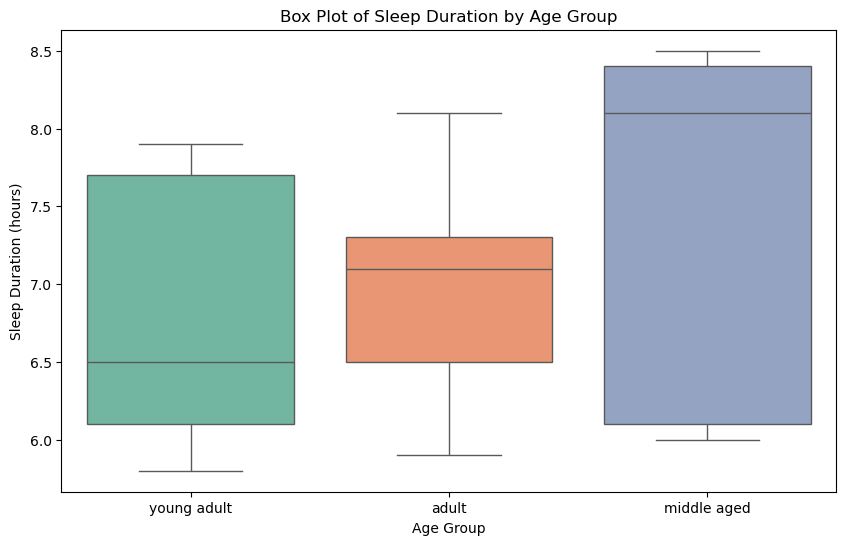

In [121]:
# box plot of sleep duration by age group
plt.figure(figsize=(10, 6))
sns.boxplot(x="Age Group", y="Sleep Duration",
            data=SleepyData_merged, palette="Set2")
plt.title("Box Plot of Sleep Duration by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Sleep Duration (hours)")
plt.show()

### Multi-Panel Visuzalization
- This multi-panel visualization provides some insight into how occupation impacts sleep duration
- Each subplot represents one occupation, with a histogram and KDE curve illustrating the distribution. 
- For example, some occupations cluster tightly around 7 hours, such as Manager, while others like Nurse show wider variation.

Sources:
- https://seaborn.pydata.org/generated/seaborn.FacetGrid.html


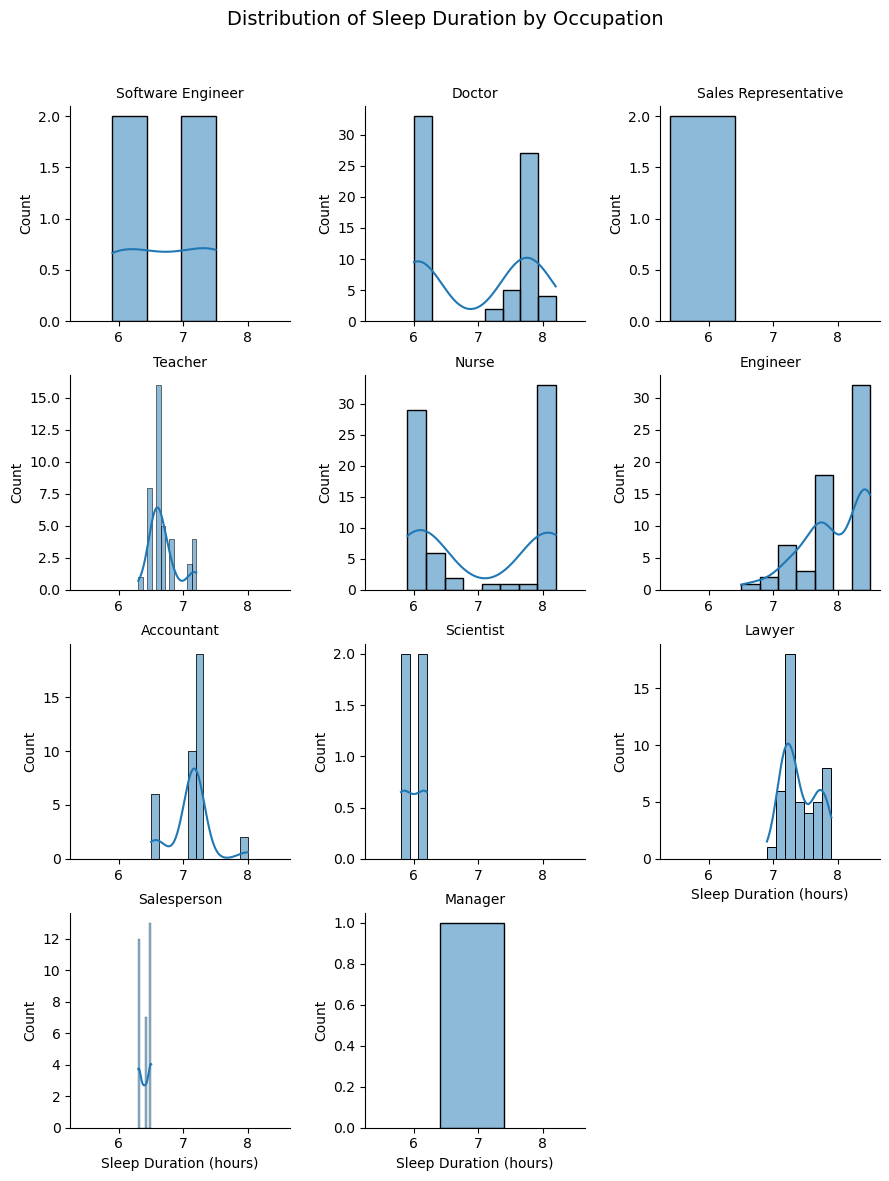

In [122]:
# multi-panel visualization - sleep duration distribution by occupation

import seaborn as sns
import matplotlib.pyplot as plt

occupation_grid = sns.FacetGrid(
    SleepyData, col="Occupation", col_wrap=3, height=3, sharey=False)
occupation_grid.map(sns.histplot, "Sleep Duration", kde=True)

occupation_grid.set_titles("{col_name}")
for ax in occupation_grid.axes.flatten():
  ax.set_xlabel("Sleep Duration (hours)")
  ax.tick_params(axis='x', which='both', labelbottom=True)

plt.subplots_adjust(top=0.9)
occupation_grid.figure.suptitle(
    "Distribution of Sleep Duration by Occupation", fontsize=14)
plt.show()

### Visualization: Time-Series Alternative
My dataset doesn't contain a time series, so for my alternative I chose to showcase the relationship between BMI and sleep duration. 

- Each bar represents the mean sleep duration for a BMI category, while the error bars indicate the uncertainty around those means.
- The visualization makes it easy to compare sleep duration patterns across BMI groups.
- For example, if one category’s bar is consistently higher, it suggests that individuals in that BMI group
- The chart seems to suggest there is only a slight difference in sleep duration between BMI levels. 

Soruces:
- https://pytutorial.com/mastering-seaborn-barplots-a-complete-guide/


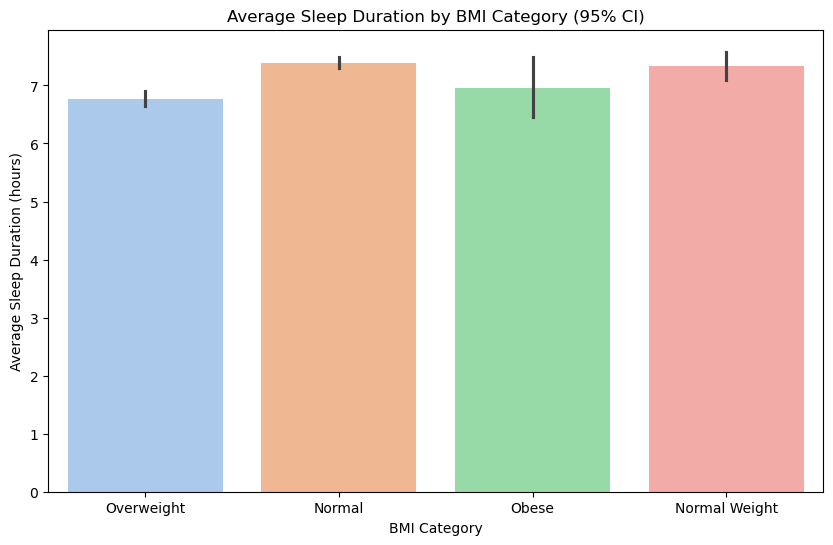

In [123]:
# Visualization: Relationship between BMI and Sleep Duration
# Dict mapping for BMI Category - created earlier
plt.figure(figsize=(10, 6))
sns.barplot(x="BMI Category", y="Sleep Duration", data=SleepyData,
            errorbar=("ci", 95), hue="BMI Category", palette="pastel", legend=False)
plt.title("Average Sleep Duration by BMI Category (95% CI)")
plt.xlabel("BMI Category")
plt.ylabel("Average Sleep Duration (hours)")
plt.show()

### Visualization: Heatmap of Average Sleep Duration by Occupation and Stress Level
- This heatmap contains elements similar to the earlier occupation multi panel visualization, taking stress into account
- It illustrates the variances seen earlier, particularly in the Nurse and Doctor fields 
- Here, we can see that high stress results in lower levels of sleep duration, reflective of the earlier chi map results. 

Sources:
- https://www.geeksforgeeks.org/python/seaborn-heatmap-a-comprehensive-guide/

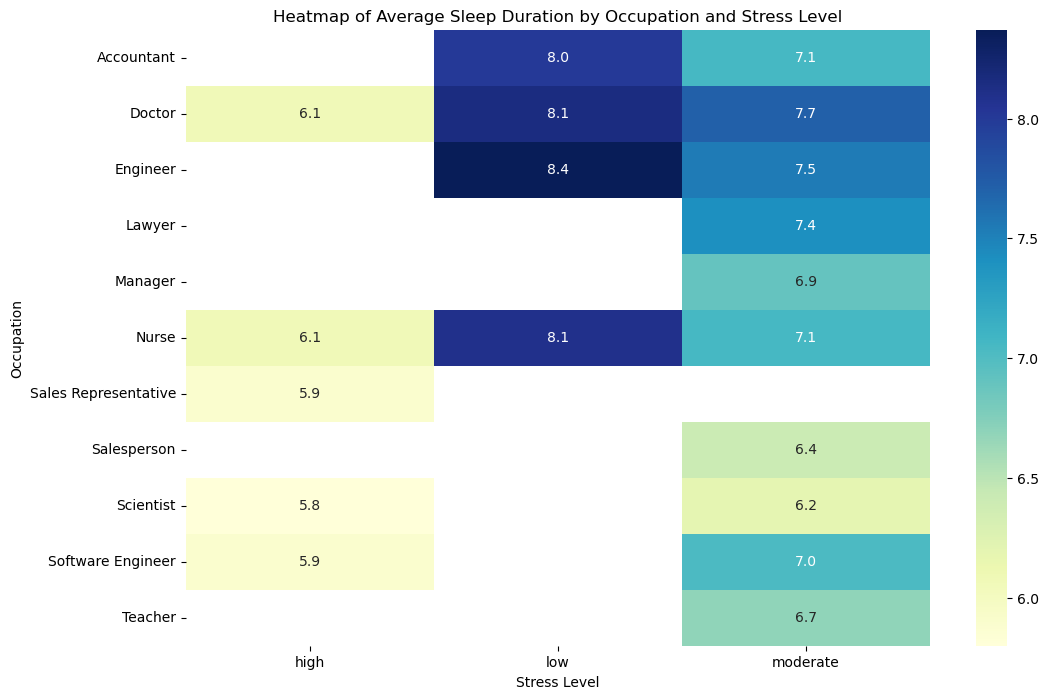

In [124]:
# Using the ccupation_metrics_pivot created earlier:
# heatmap of sleep duration vs stress level by occupation

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(occupation_metrics_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap of Average Sleep Duration by Occupation and Stress Level")
plt.show()

### Visualization: Interactive Plotly Chart
- This interactive chart shows the average sleep duration across ages
- Hovering over each point allows you to see the age and mean sleep of that group 
- It shows an upward trend, reflective of the earlier findings that middle-aged individuals sleep longer on average. 
- This visualization complements my earlier ANOVA test, visually showcasing that age group is a significant factor influencing sleep duration.

In [142]:
# Interactive plotly chart - interactive line chart of sleep duration vs age, with hover info
import plotly.express as px
from IPython.display import IFrame

age_sleep = SleepyData.groupby("Age", as_index=False)["Sleep Duration"].mean()
fig = px.line(age_sleep, x="Age", y="Sleep Duration",
              hover_data=["Age"])
fig.update_traces(mode="lines+markers")
fig.update_layout(title="Average Sleep Duration by Age")
fig.write_html("plotly_chart.html")
IFrame("plotly_chart.html", width=800, height=600)
fig.show()

# Conclusions

This analysis explored how multiple factors influence sleep duration and quality, including stress, BMI, occupation, physical activity level, gender, and age.  The conclusions of this analysis are: 
- **Stress**: A chi‑square test showcased a strong association between stress level and sleep quality. Higher stress was associated with low sleep quality, while low stress was associated with high sleep quality. Interestingly, there were no reports of low sleep quality. 
- **BMI**: A barchart revealed a slight variance in sleep duration by BMI. 
- **Occupation**: A multi panel fiugure and heatmap illustrated steep variation in sleep duration by occupation. Some occupations clustered tightly around 7 hours, such as Manager, while others like Nurse showed wider variation.
- **Physical activity level**: Both Pearson and Spearman correlations showed a small but statistically significant positive relationship between increased physical activity levels and sleep duration.
- **Gender**: A grouped comparison with Welch's t test proved that women sleep slightly longer (0.3-0.35 or 1.8-21 minutes)
- **Age**: ANOVA confirmed that sleep duration varies significantly across age groups. Middle‑aged individuals slept the longest on average, while young adults slept the least.

### Limitations
- This is a synthetic dataset with limited variables and results may be exxagerated or diminished from real world scenarios.  Nonetheless, the associations found within this analysis are significant and could provide valuable insight into sleep health and habits. 

# Appendix
### Resources and References 

- https://www.statology.org/understanding-anova-when-and-how-to-use-it-in-your-research/
- https://www.geeksforgeeks.org/python/how-to-perform-a-one-way-anova-in-python/
- https://coderivers.org/blog/analysis-of-variance-python/
- https://www.datacamp.com/tutorial/anova-test
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
- https://www.statology.org/seaborn-scatterplot-with-correlation-coefficient/
- https://seaborn.pydata.org/generated/seaborn.regplot.html
- https://tidystat.com/conduct-correlation-in-python/
- https://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlation
- https://www.surveymonkey.com/market-research/resources/pearson-correlation-vs-spearman-correlation/
- https://www.graphpad.com/guides/prism/latest/statistics/stat_chi-square_or_fishers_test.htm
- https://www.geeksforgeeks.org/python/python-pearsons-chi-square-test/
- https://www.geeksforgeeks.org/machine-learning/welchs-t-test-in-python/
- https://www.datanovia.com/en/lessons/t-test-effect-size-using-cohens-d-measure/
- https://machinelearningmastery.com/effect-size-measures-in-python/
- https://datagy.io/python-confidence-intervals/
- https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset